In [14]:
import re
import glob
from collections import OrderedDict, defaultdict
import matplotlib.pyplot as plt
import pysam
from pyBioInfo.Range import GRange
from pyBioInfo.IO.File import GffFile, BedFile
from pyBioInfo.Utils import ShiftLoader

# SimpleRepeats and LowComplexity from RepeatMasker

In [3]:
def load_rmsk(path):
    array = []
    with GffFile(path) as f:
        for x in f:
            if re.match("^chr([0-9]+|[XY])$", x.chrom):
                array.append(x)
    return array
rmsk = load_rmsk("/home/chenzonggui/species/RepeatMasker/mm10.rmsk.gff.gz")

In [5]:
! mkdir -p stratifications

with open("stratifications/GRCm38_SimpleRepeats.bed", "w+") as fw:
    for x in rmsk:
        name = x.attributes["Name"]
        name = name[name.find("_") + 1:]
        if "Simple_repeat" in name:
            fw.write("\t".join(map(str, [x.chrom, x.start, x.end, name])) + "\n")

with open("stratifications/GRCm38_SimpleRepeats_gt200bp.bed", "w+") as fw:
    for x in rmsk:
        name = x.attributes["Name"]
        name = name[name.find("_") + 1:]
        if "Simple_repeat" in name and len(x) > 200:
            fw.write("\t".join(map(str, [x.chrom, x.start, x.end, name])) + "\n")
            
with open("stratifications/GRCm38_SimpleRepeats_gt500bp.bed", "w+") as fw:
    for x in rmsk:
        name = x.attributes["Name"]
        name = name[name.find("_") + 1:]
        if "Simple_repeat" in name and len(x) > 500:
            fw.write("\t".join(map(str, [x.chrom, x.start, x.end, name])) + "\n")
            
with open("stratifications/GRCm38_LowComplexity.bed", "w+") as fw:
    for x in rmsk:
        name = x.attributes["Name"]
        name = name[name.find("_") + 1:]
        if "Low_complexity" in name:
            fw.write("\t".join(map(str, [x.chrom, x.start, x.end, name])) + "\n")

with open("stratifications/GRCm38_LowComplexity_gt200bp.bed", "w+") as fw:
    for x in rmsk:
        name = x.attributes["Name"]
        name = name[name.find("_") + 1:]
        if "Low_complexity" in name and len(x) > 200:
            fw.write("\t".join(map(str, [x.chrom, x.start, x.end, name])) + "\n")
            
with open("stratifications/GRCm38_LowComplexity_gt500bp.bed", "w+") as fw:
    for x in rmsk:
        name = x.attributes["Name"]
        name = name[name.find("_") + 1:]
        if "Low_complexity" in name and len(x) > 500:
            fw.write("\t".join(map(str, [x.chrom, x.start, x.end, name])) + "\n")

# TandemRepeats

In [6]:
! awk '$3-$2>500' GRCm38_DBA_ONT/GRCm38.tandemRepeats.bed > stratifications/GRCm38_TandemRepeats_gt500bp.bed

# Processing Sniffles2 structure variants

In [10]:
infile = "GRCm38_DBA_ONT/GRCm38_DBA_ONT.sniffles2.filtered.vcf.gz"
outfile = "GRCm38_C57DBA_SV_benchmark_callsets.vcf"
records_lt50bp = []
records_gt10000bp = []
records_failed = []
records_imprecise = []
records_cluster = []
svs = [] # SVLEN >= 50

with pysam.VariantFile(infile) as f, open(outfile, "w+") as fw:
    for line in str(f.header).strip("\n").split("\n"):
        if line.startswith("##"):
            fw.write(line + "\n")
        else:
            fw.write('##FORMAT=<ID=IGT,Number=1,Type=String,Description="Original input genotype">\n')
            fw.write('##FORMAT=<ID=IPS,Number=1,Type=String,Description="Phase set for IGT">\n')
            fw.write('##FORMAT=<ID=PS,Number=1,Type=String,Description="Phase set for GT">\n')
            fw.write("#CHROM\tPOS\tID\tREF\tALT\tQUAL\tFILTER\tINFO\tFORMAT\tC57DBA\n")
            
    for i, record in enumerate(f):
        if i >= 1000:
            pass
            # break
        svtype = record.info["SVTYPE"]
        assert svtype == "DEL" or svtype == "INS"
        
        svlen = abs(record.info["SVLEN"])
        
        row = str(record).strip("\n").split("\t")
        d = OrderedDict()
        for k, v in zip(row[8].split(":"), row[9].split(":")):
            d[k] = v
        d["IGT"] = d["GT"]
                
        FS = row[6].split(";")
        # gq = int(d["GQ"])
        dr = int(d["DR"])
        dv = int(d["DV"])
        cov = dr + dv
        af = record.info["AF"]
        if FS[0] == "PASS":
            FS = []
            if svlen >= 50:
                if svlen > 10000:
                    records_gt10000bp.append(record)
                if d["GT"] == "1/1":
                    d["GT"] = "0|1"
                    d["PS"] = "0"
                    if af < 0.9:
                        records_failed.append(record)
                        FS.append("GT")
                    if record.info["IMPRECISE"]:
                        records_imprecise.append(record)
                else:
                    records_failed.append(record)
                    FS.append("GT")
                if cov < 15:
                    records_failed.append(record)
                    FS.append("COV_MIN")
            else:
                records_lt50bp.append(record)
                FS.append("SVLEN_MIN")
                if d["GT"] == "1/1":
                    d["GT"] = "0|1"
                    d["PS"] = "0"
                else:
                    FS.append("GT")
                if cov < 15:
                    FS.append("COV_MIN")
        else:
            if svlen >= 50:
                records_failed.append(record)
            else:
                records_lt50bp.append(record)
                FS.append("SVLEN_MIN")
                
        if svlen >= 50:
            sv = GRange(chrom=record.chrom, start=record.start, end=record.stop)
            sv.record = record
            svs.append(sv)
            
        if len(FS) == 0:
            FS = ["PASS"]
        row[6] = ";".join(sorted(set(FS)))
        row[8] = ":".join(d.keys())
        row[9] = ":".join(d.values())
        line = "\t".join(map(str, row))
        fw.write(line + "\n")
        
svs.sort()
loader = ShiftLoader(svs)
for sv in svs:
    for sv2 in loader.fetch(chrom=sv.chrom, start=sv.start - 1000, end=sv.end + 1000):
        if sv2 is sv:
            continue
        records_cluster.append(sv.record)
        break
        
! bgzip -f {outfile}
! tabix -f -p vcf {outfile}.gz

In [11]:
print("SVs shorter than 50bp:", len(records_lt50bp))
print("SVs longer than 10kb:", len(records_gt10000bp))
print("SVs filter:", len(records_failed))
print("SVs imprecise:", len(records_imprecise))
print("SVs in cluster:", len(records_cluster))

SVs shorter than 50bp: 101446
SVs longer than 10kb: 171
SVs filter: 15818
SVs imprecise: 6770
SVs in cluster: 17846


In [12]:
sizes = "/home/chenzonggui/species/mus_musculus/GRCm38.p6/GRCm38.canonical.genome.sizes"

outfile1 = "stratifications/GRCm38_C57DBA_SV_lt50bp.bed"
outfile2 = "stratifications/GRCm38_C57DBA_SV_lt50bp_slop100bp.bed"
with open(outfile1, "w+") as fw:
    for x in records_lt50bp:
        fw.write("\t".join(map(str, [x.chrom, x.start, x.stop])) + "\n")
! bedtools slop -i {outfile1} -g {sizes} -b 100 > {outfile2}

outfile1 = "stratifications/GRCm38_C57DBA_SV_gt10000bp.bed"
outfile2 = "stratifications/GRCm38_C57DBA_SV_gt10000bp_slop1000bp.bed"
with open(outfile1, "w+") as fw:
    for x in records_gt10000bp:
        fw.write("\t".join(map(str, [x.chrom, x.start, x.stop])) + "\n")
! bedtools slop -i {outfile1} -g {sizes} -b 1000 > {outfile2}

outfile1 = "stratifications/GRCm38_C57DBA_SV_failed.bed"
outfile2 = "stratifications/GRCm38_C57DBA_SV_failed_slop1000bp.bed"
with open(outfile1, "w+") as fw:
    for x in records_failed:
        fw.write("\t".join(map(str, [x.chrom, x.start, x.stop])) + "\n")
! bedtools slop -i {outfile1} -g {sizes} -b 1000 > {outfile2}

outfile1 = "stratifications/GRCm38_C57DBA_SV_imprecise.bed"
outfile2 = "stratifications/GRCm38_C57DBA_SV_imprecise_slop1000bp.bed"
with open(outfile1, "w+") as fw:
    for x in records_imprecise:
        fw.write("\t".join(map(str, [x.chrom, x.start, x.stop])) + "\n")
! bedtools slop -i {outfile1} -g {sizes} -b 1000 > {outfile2}

outfile1 = "stratifications/GRCm38_C57DBA_SV_cluster.bed"
outfile2 = "stratifications/GRCm38_C57DBA_SV_cluster_slop1000bp.bed"
with open(outfile1, "w+") as fw:
    for x in records_cluster:
        fw.write("\t".join(map(str, [x.chrom, x.start, x.stop])) + "\n")
! bedtools slop -i {outfile1} -g {sizes} -b 1000 > {outfile2}

In [15]:
for path in glob.glob("stratifications/*.bed"):
    ! sort -k1,1 -k2,2n {path} | bedtools merge -d 100 -i - | bgzip -c > {path}.gz
    ! tabix -f -p bed {path}.gz
    ! rm {path}

In [16]:
! zcat \
    stratifications/GRCm38_C57DBA_SV_cluster_slop1000bp.bed.gz \
    stratifications/GRCm38_C57DBA_SV_lt50bp_slop100bp.bed.gz \
    stratifications/GRCm38_C57DBA_SV_gt10000bp_slop1000bp.bed.gz \
    stratifications/GRCm38_C57DBA_SV_failed_slop1000bp.bed.gz \
    stratifications/GRCm38_C57DBA_SV_imprecise_slop1000bp.bed.gz \
    stratifications/GRCm38_TandemRepeats_gt500bp.bed.gz \
    stratifications/GRCm38_LowComplexity_gt500bp.bed.gz \
    stratifications/GRCm38_SimpleRepeats_gt500bp.bed.gz \
    | cut -f1-3 | sort -k1,1 -k2,2n | bedtools merge -d 100 -i - \
    | sort -k1,1 -k2,2n > GRCm38_C57DBA_SV_benchmark_blacklist.bed
! bgzip -f -c GRCm38_C57DBA_SV_benchmark_blacklist.bed > GRCm38_C57DBA_SV_benchmark_blacklist.bed.gz
! tabix -f -p bed GRCm38_C57DBA_SV_benchmark_blacklist.bed.gz

# High-confident structure variants

In [18]:
with BedFile("GRCm38_C57DBA_SV_benchmark_blacklist.bed.gz") as f:
    regions = [x for x in f]
print("Blacklist regions:", len(regions))
    
svs = []
with pysam.VariantFile("GRCm38_C57DBA_SV_benchmark_callsets.vcf.gz") as f:
    for x in f:
        svlen = abs(x.info["SVLEN"])
        if list(x.filter)[0] == "PASS" and svlen >= 50:
            sv = GRange(chrom=x.chrom, start=x.start, end=x.stop)
            sv.record = x
            svs.append(sv)
svs.sort()
print("Total SVs:", len(svs))

loader = ShiftLoader(regions)
tmp = []
for sv in svs:
    if len(list(loader.fetch(obj=sv))) == 0:
        tmp.append(sv)
svs1 = tmp
print("Filtered SVs:", len(svs1))

Blacklist regions: 122963
Total SVs: 52071
Filtered SVs: 34828


In [19]:
counter = defaultdict(int)
for sv in svs1:
    counter[sv.record.info["SVTYPE"]] += 1
print("Number of deletion:", counter["DEL"])
print("Number of insertion:", counter["INS"])

Number of deletion: 17171
Number of insertion: 17657


In [22]:
counter = defaultdict(int)
for sv in svs1:
    svtype = sv.record.info["SVTYPE"]
    gt = sv.record.samples["C57DBA"]["GT"]
    ps = sv.record.samples["C57DBA"]["PS"]
    counter[(svtype, gt, ps)] += 1
print("Number\tSVTYPE\tGT\tPS")
print("-" * 30)
for k, v in sorted(counter.items()):
    print(v, *k, sep="\t")

Number	SVTYPE	GT	PS
------------------------------
17171	DEL	(0, 1)	0
17657	INS	(0, 1)	0


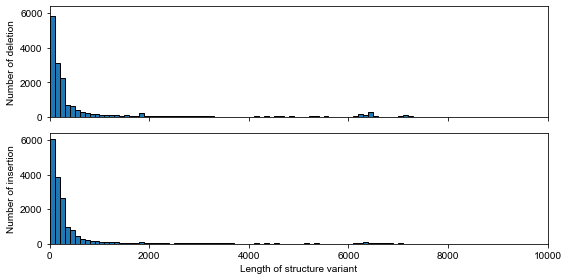

In [20]:
vs1 = []
vs2 = []
for sv in svs1:
    if sv.record.info["SVTYPE"] == "DEL":
        vs1.append(abs(sv.record.info["SVLEN"]))
    else:
        vs2.append(abs(sv.record.info["SVLEN"]))
        
fig, axs = plt.subplots(2, 1, figsize=(8, 4), sharex=True, sharey=True)

plt.sca(axs[0])
plt.hist(vs1, range=(0, 10000), bins=100, edgecolor="black")
plt.ylabel("Number of deletion")

plt.sca(axs[1])
plt.hist(vs2, range=(0, 10000), bins=100, edgecolor="black")
plt.ylabel("Number of insertion")
plt.xlabel("Length of structure variant")

plt.xlim(0, 10000)

plt.tight_layout()
plt.show()
plt.close()